In [107]:
import xgboost as xgb
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import warnings
import operator

from sklearn.metrics import accuracy_score, zero_one_loss, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.grid_search import GridSearchCV

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
data_set = pd.read_csv('BlogFeedback/blogData_train.csv', header=None)
dlabes = data_set[:][280]
data_set.drop(data_set.columns[[280]], inplace=True, axis=1)

In [74]:
border = len(data_set)/3
dtrain, ytrain = data_set[:border], dlabes[:border]
dtest, ytest = data_set[border:], dlabes[border:]

Для начала реализуем два метода. Первый по заданной обучающей выборки, ответам и дипозону, в котором варируется параметр n_estimator количества деревьев в random forest, возвращает список ошибок для каждого n_estimator.

In [ ]:
def get_oob_errors(X_train, y_train, n_min, n_max):
    oob_errors = {}
    for i in xrange(n_min, n_max + 1):
        model = RandomForestRegressor(oob_score=True, n_estimators=i).fit(X_train, y_train)
        oob_errors[i] = 1 - model.oob_score_
    return oob_errors

In [34]:
def plot_oob_errors(estimators, oob_errors):
    plt.figure(figsize=(14, 8))
    plt.xlabel("n_estimators", fontsize=15)
    plt.ylabel("oob_error", fontsize=15)
    plt.plot(estimators, oob_errors)
    return plt

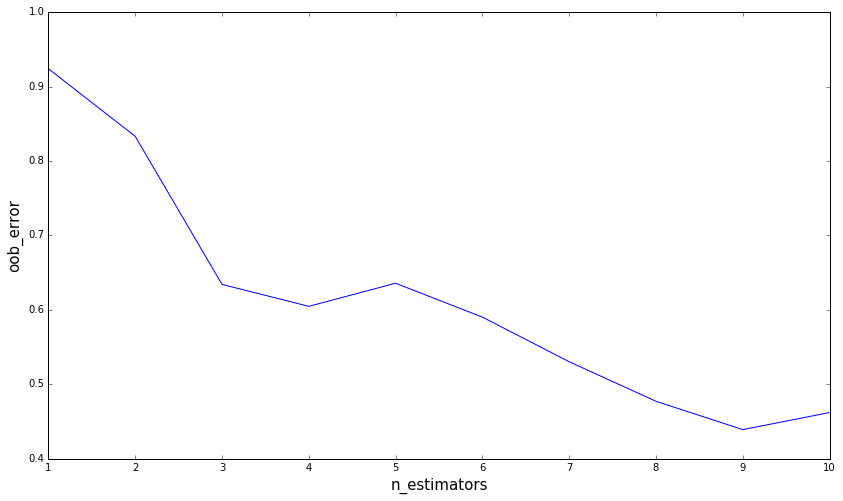

In [99]:
errors = get_oob_errors(dtrain, ytrain, 1, 10)
plot_oob_errors(errors.keys(), errors.values()).show()

In [46]:
def get_errors(algorithm, X_train, y_train, n_min, n_max, X_test=None, y_test=None):
    if X_test is None or y_test is None:
        X_test, y_test = X_train, y_train
    errors = {}
    for i in xrange(n_min, n_max + 1):
        if algorithm == 'RFR': model = RandomForestRegressor(n_estimators=i).fit(X_train, y_train)
        elif algorithm == 'GBR': model = GradientBoostingRegressor(n_estimators=i).fit(X_train, y_train)
        elif algorithm == 'xgboost': model = xgb.XGBRegressor(n_estimators=i).fit(X_train, y_train)
        errors[i] = mean_squared_error(y_test, model.predict(X_test))
    return errors

In [44]:
def plot_errors(estimators, errors):
    plt.figure(figsize=(14, 8))
    plt.xlabel("n_estimators", fontsize=15)
    plt.ylabel("error", fontsize=15)
    plt.plot(estimators, errors)
    return plt

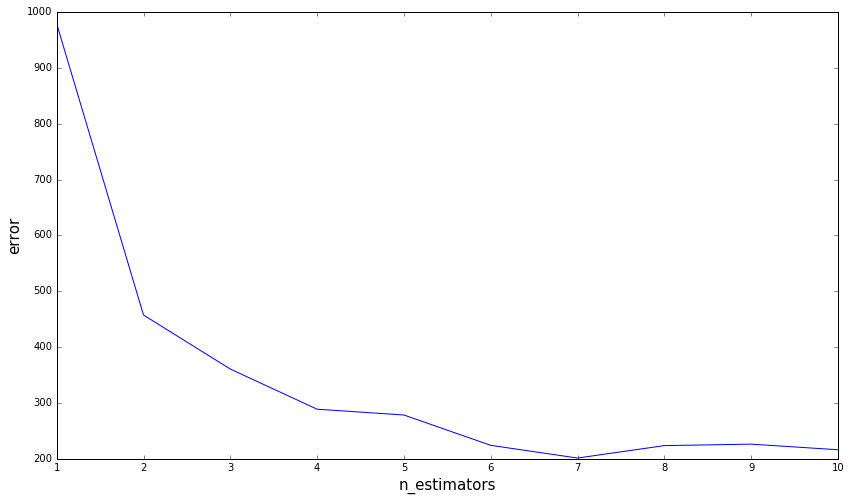

In [121]:
errors = get_errors('RFR', dtrain, ytrain, 1, 10)
plot_errors(errors.keys(), errors.values()).show()

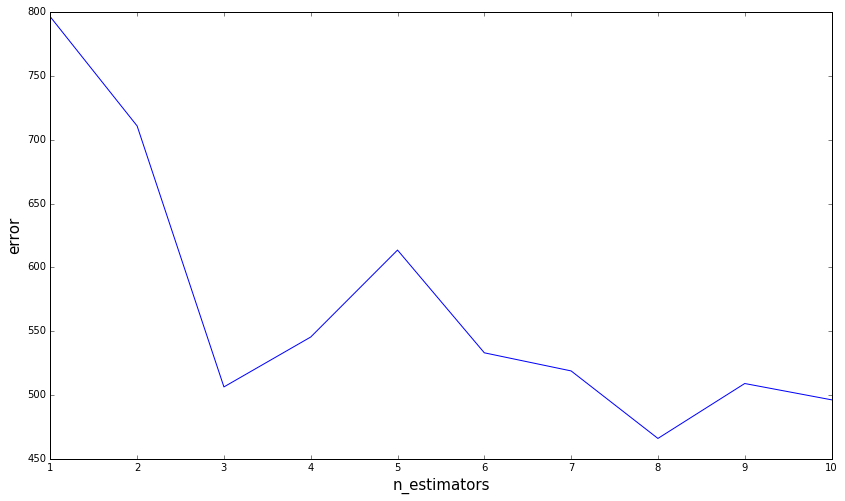

In [122]:
errors = get_errors('RFR', dtrain, ytrain, 1, 10, dtest, ytest)
plot_errors(errors.keys(), errors.values()).show()

In [129]:
model = RandomForestRegressor(oob_score=True, n_estimators=15).fit(dtrain, ytrain)

0.95814665267840471

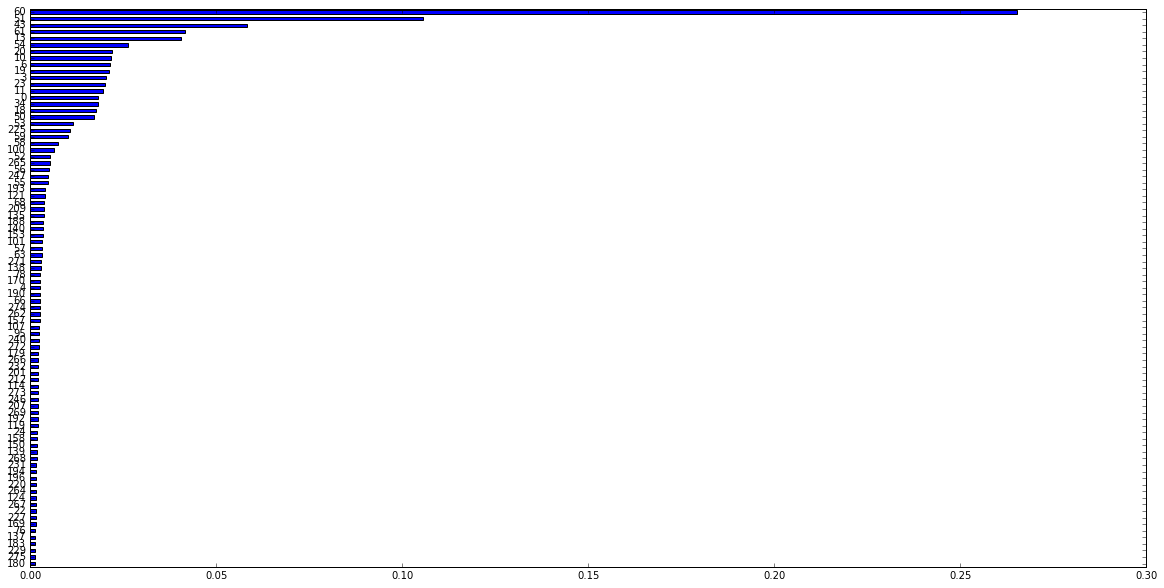

In [130]:
feature_importances1 = pd.Series(model.feature_importances_, index=dtrain.columns)
feature_importances1.sort()
feature_importances1 = feature_importances1[-85:]
feature_importances1.plot(kind="barh", figsize=(20, 10))
sum(feature_importances1.values)

In [102]:
errors_all_features = get_oob_errors(dtrain, ytrain, 1, 30)
errors_choosen_features = get_oob_errors(dtrain[feature_importances.keys()], ytrain, 1, 30)

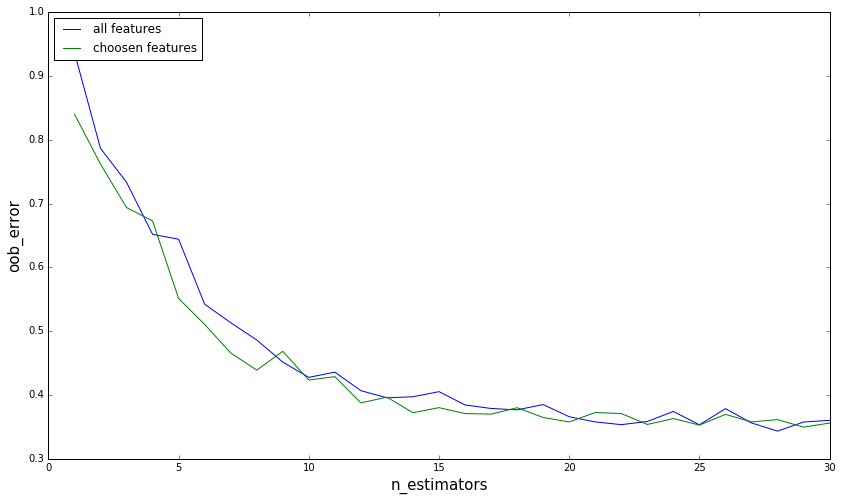

In [103]:
plt = plot_oob_errors(errors_all_features.keys(), errors_all_features.values())
plt.plot(errors_choosen_features.keys(), errors_choosen_features.values())
plt.legend(['all features', 'choosen features'], loc='upper left')
plt.show()

In [126]:
errors_all_features = get_errors(dtrain, ytrain, 1, 60, dtest, ytest)
errors_choosen_features = get_errors(dtrain[feature_importances.keys()], ytrain, 1, 60,
                                         dtest[feature_importances.keys()], ytest)

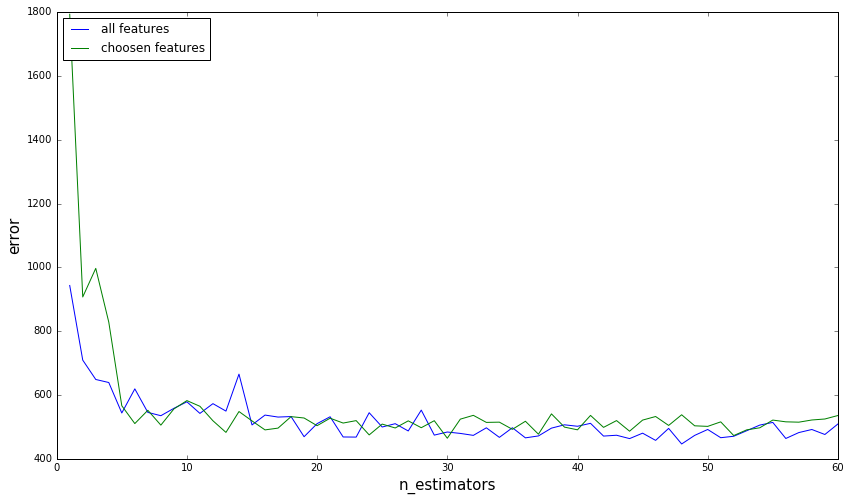

In [127]:
plt = plot_errors(errors_all_features.keys(), errors_all_features.values())
plt.plot(errors_choosen_features.keys(), errors_choosen_features.values())
plt.legend(['all features', 'choosen features'], loc='upper left')
plt.show()

In [112]:
def estimate_count_of_iterations(algorithm, dtrayn, ytrain, dtest, ytest, eps=30):
    count_of_iteration = {}
    for mf in xrange(1, 251, 50):
        for mss in xrange(2, 11, 2):
            step, i, score1, score2 = 1, 0, 1, 0
            while i < 10 :
                if algorithm == 'RFR':
                    model = RandomForestRegressor(n_estimators=step, max_features=mf,
                                                  min_samples_split=mss).fit(dtrain, ytrain)
                elif algorithm == 'GBR':
                    model = GradientBoostingRegressor(n_estimators=step, max_features=mf,
                                                    min_samples_split=mss).fit(dtrain, ytrain)
                step += 1
                if step == 2: score1 = mean_squared_error(ytest, model.predict(dtest))
                else:
                    score2 = score1
                    score1 = mean_squared_error(ytest, model.predict(dtest))
                print abs(score2 - score1)
                if abs(score2 - score1) < eps: i += 1
                else: i = 0
            count_of_iteration[(mf, mss)] = step
        print count_of_iteration
    return count_of_iteration

In [ ]:
count_of_iteration = estimate_count_of_iterations('RFR', dtrain, ytrain, dtest, ytest, 50)

In [39]:
count_of_iteration

{(1, 2): 57,
 (1, 4): 32,
 (1, 6): 33,
 (1, 8): 25,
 (1, 10): 36,
 (51, 2): 49,
 (51, 4): 62,
 (51, 6): 26,
 (51, 8): 44,
 (51, 10): 51,
 (101, 2): 44,
 (101, 4): 60,
 (101, 6): 56,
 (101, 8): 26,
 (101, 10): 49,
 (151, 2): 29,
 (151, 4): 22,
 (151, 6): 39,
 (151, 8): 44,
 (151, 10): 46,
 (201, 2): 42,
 (201, 4): 30,
 (201, 6): 38,
 (201, 8): 19,
 (201, 10): 25}

По сетке параметров сверху можно заметить, что наиболее быстрая(по количеству итераций) сходимость достигается при использовании параметров (201, 8) и на это затрачивается 19 шагов. То есть на то чтобы сойтись достаточно 9 шагов. Посмтроим график зависимости ошибки на тесте и на обучении.

In [118]:
errors = {}
for i in xrange(1, 20):
    model = RandomForestRegressor(n_estimators=i, max_features=201, min_samples_split=8).fit(dtrain, ytrain)
    errors[i] = mean_squared_error(ytest, model.predict(dtest))

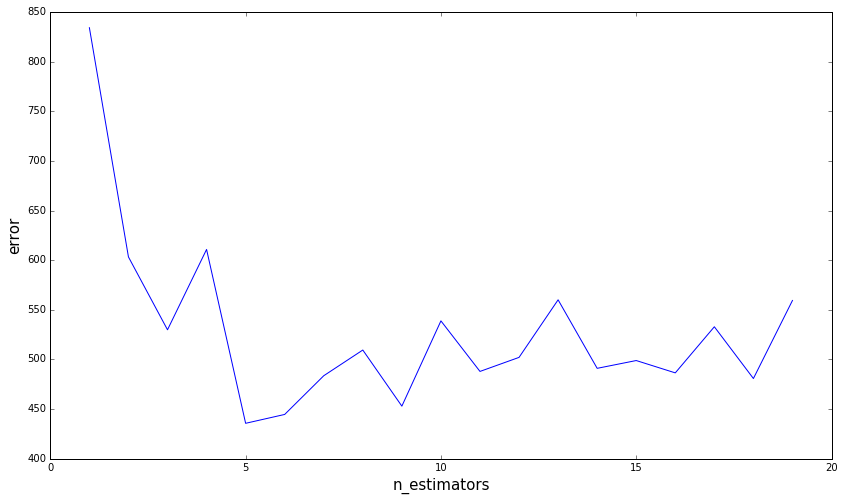

In [119]:
plot_errors(errors.keys(), errors.values()).show()

In [121]:
errors = {}
for i in xrange(1, 20):
    model = RandomForestRegressor(n_estimators=i, max_features=201, min_samples_split=8).fit(dtrain, ytrain)
    errors[i] = mean_squared_error(ytrain, model.predict(dtrain))

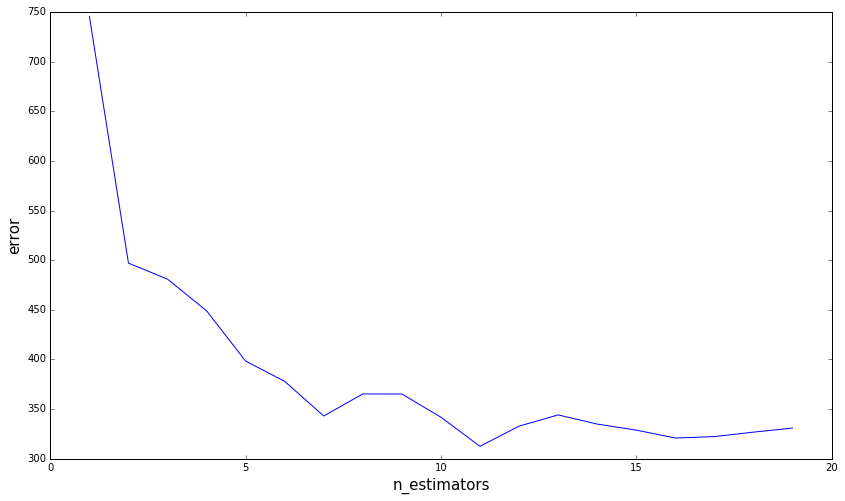

In [122]:
plot_errors(errors.keys(), errors.values()).show()

Для того, чтобы продемонтрировать матрицу ошибок, нужно как минимум запустить алгоритм классификации. На которой у меня не хватает оперативки. Это кстати и была одна из причин, что почему я выбрал регрессию. Первая, что на первый взгляд мне показалось, что множество классов довольно большое. Ну и вторая, это оперативки ест больше. Но тут я оставил два метода, которые визуализируют матрицу ошибок.

In [103]:
def error_normalized_matrix_plot(y_predicted, y_test):
    error_matrix = confusion_matrix(y_test, y_predicted)
    em_normalized = cm.astype('float') / error_matrix.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(14,8))
    plt.ylabel("real labels", fontsize=12)
    plt.xlabel("predicted labels", fontsize=12)
    plt.title('Normalized Confusion Matrix', fontsize=15)
    plt.imshow(em_normalized, interpolation='none')
    return(plt)

In [ ]:
model = RandomForestClassifier(n_estimators=step, max_features=mf, min_samples_split=mss).fit(dtrain, ytrain)
y_predicted = model.predict(dtest)
plt_matrix = error_normalized_matrix_plot(y_predicted, ytest)
plt_matrix.show()

Проведем аналогичные исследования для градиентного бустинга из scikitlearn и xgboost.

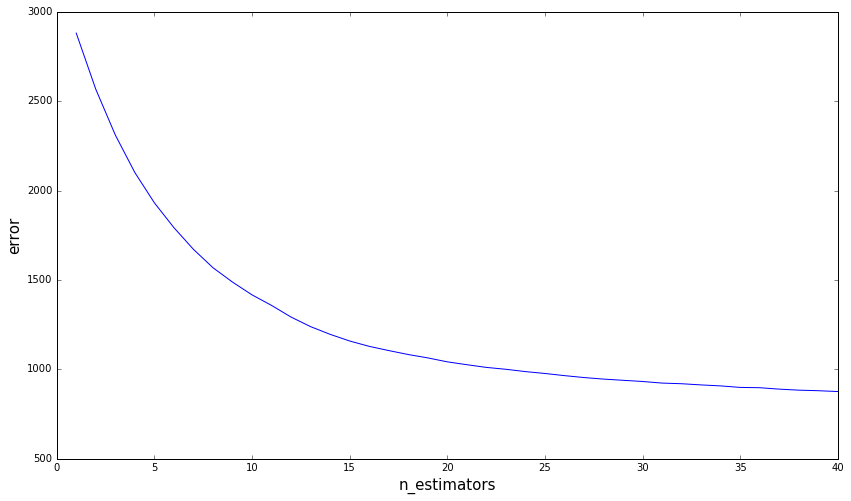

In [55]:
errors = get_errors('GBR', dtrain, ytrain, 1, 40)
plot_errors(errors.keys(), errors.values()).show()

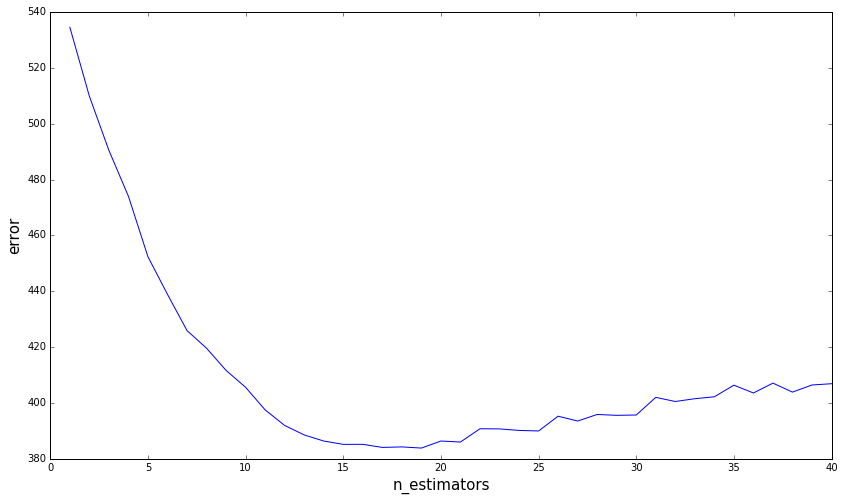

In [54]:
errors = get_errors('GBR', dtrain, ytrain, 1, 40, dtest, ytest)
plot_errors(errors.keys(), errors.values()).show()

0.94871963950397176

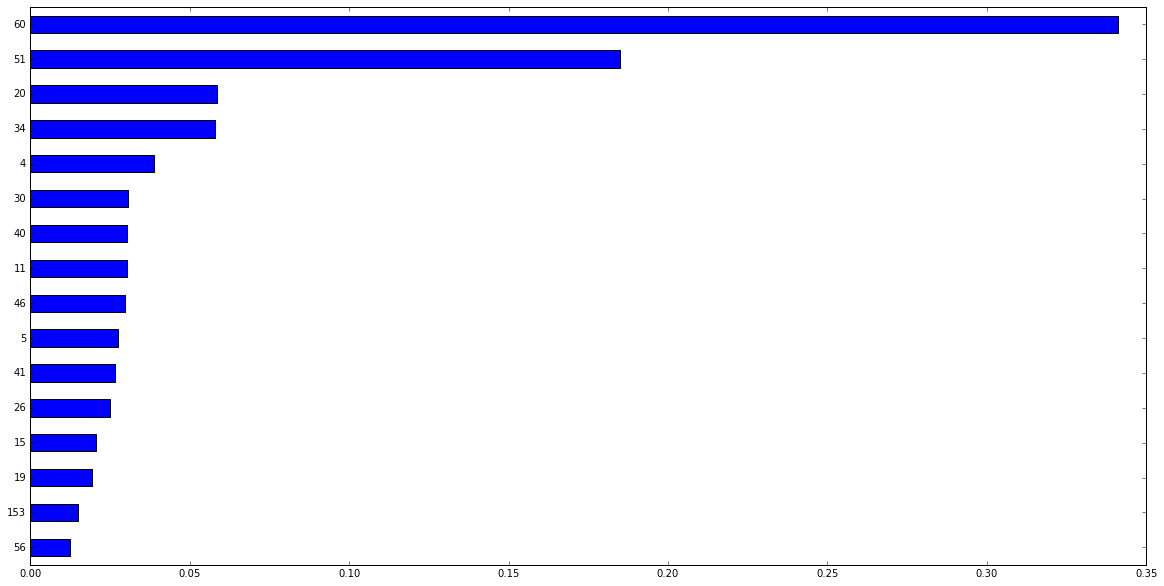

In [131]:
model = GradientBoostingRegressor(n_estimators=15).fit(dtrain, ytrain)
feature_importances2 = pd.Series(model.feature_importances_, index=dtrain.columns)
feature_importances2.sort()
feature_importances2 = feature_importances2[-16:]
feature_importances2.plot(kind="barh", figsize=(20, 10))
sum(feature_importances2.values)

In [10]:
errors_all_features = get_errors('GBR', dtrain, ytrain, 1, 30)
errors_choosen_features = get_errors('GBR', dtrain[feature_importances.keys()], ytrain, 1, 30)

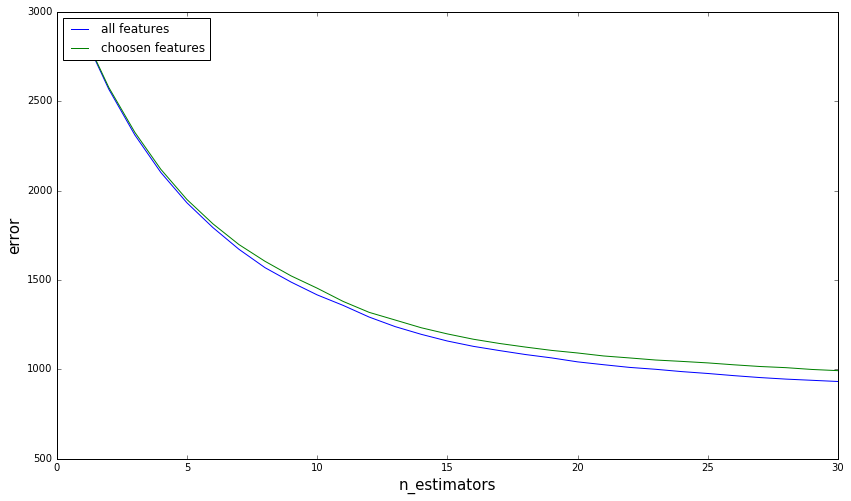

In [11]:
plt = plot_errors(errors_all_features.keys(), errors_all_features.values())
plt.plot(errors_choosen_features.keys(), errors_choosen_features.values())
plt.legend(['all features', 'choosen features'], loc='upper left')
plt.show()

In [ ]:
count_of_iteration = estimate_count_of_iterations('GBR', dtrain, ytrain, dtest, ytest, 50)

In [124]:
count_of_iteration

{(1, 2): 12,
 (1, 4): 15,
 (1, 6): 12,
 (1, 8): 12,
 (1, 10): 12,
 (51, 2): 12,
 (51, 4): 12,
 (51, 6): 61,
 (51, 8): 17,
 (51, 10): 12,
 (101, 2): 12,
 (101, 4): 12,
 (101, 6): 16,
 (101, 8): 12,
 (101, 10): 12,
 (151, 2): 12,
 (151, 4): 21,
 (151, 6): 12,
 (151, 8): 12,
 (151, 10): 12,
 (201, 2): 12,
 (201, 4): 12,
 (201, 6): 12,
 (201, 8): 12,
 (201, 10): 12}

Тут сходимость очень быстрая.

In [125]:
errors = {}
for i in xrange(1, 20):
    model = GradientBoostingRegressor(n_estimators=i, max_features=201, min_samples_split=2).fit(dtrain, ytrain)
    errors[i] = mean_squared_error(ytest, model.predict(dtest))

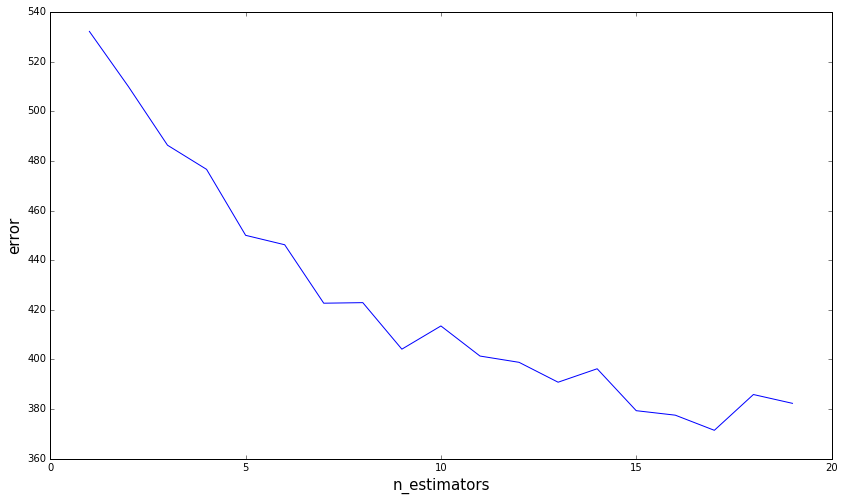

In [126]:
plot_errors(errors.keys(), errors.values()).show()

Теперь для xgboost.

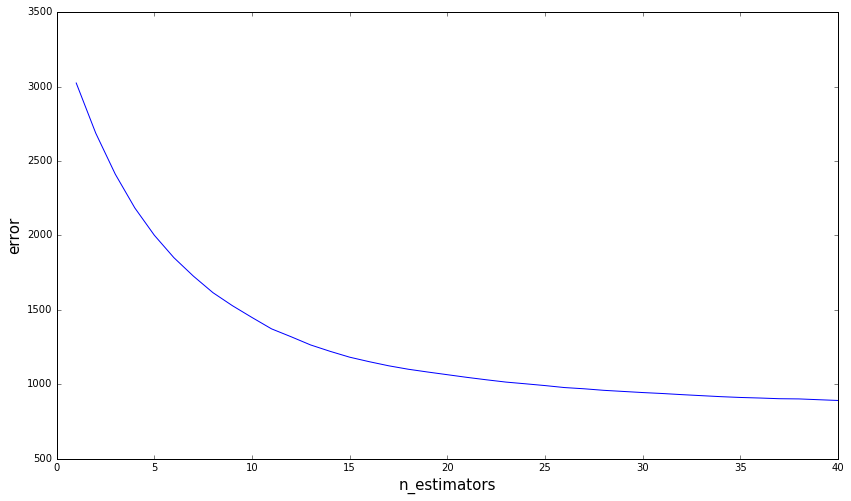

In [52]:
errors = get_errors('xgboost', np.array(dtrain), np.array(ytrain), 1, 40)
plot_errors(errors.keys(), errors.values()).show()

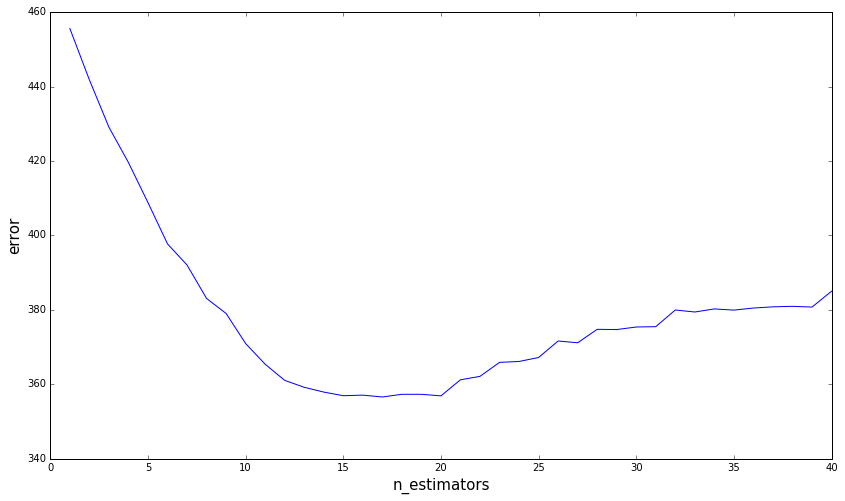

In [51]:
errors = get_errors('xgboost', np.array(dtrain), np.array(ytrain), 1, 40, np.array(dtest), np.array(ytest))
plot_errors(errors.keys(), errors.values()).show()

После постраения графиков, можно сделать вывод, что градиентный бустинг переобучается быстро в отличие random forest. При этом показывает более быструю сходимость и более высокую точность.

In [ ]:
xgb_params = {"objective": "reg:linear", "eta": 0.01, "max_depth": 8, "seed": 42, "silent": 1}
num_rounds = 1000
ndtrain = xgb.DMatrix(np.array(dtrain), label=np.array(ytrain))
gbdt = xgb.train(xgb_params, ndtrain, num_rounds)

0.953271192868


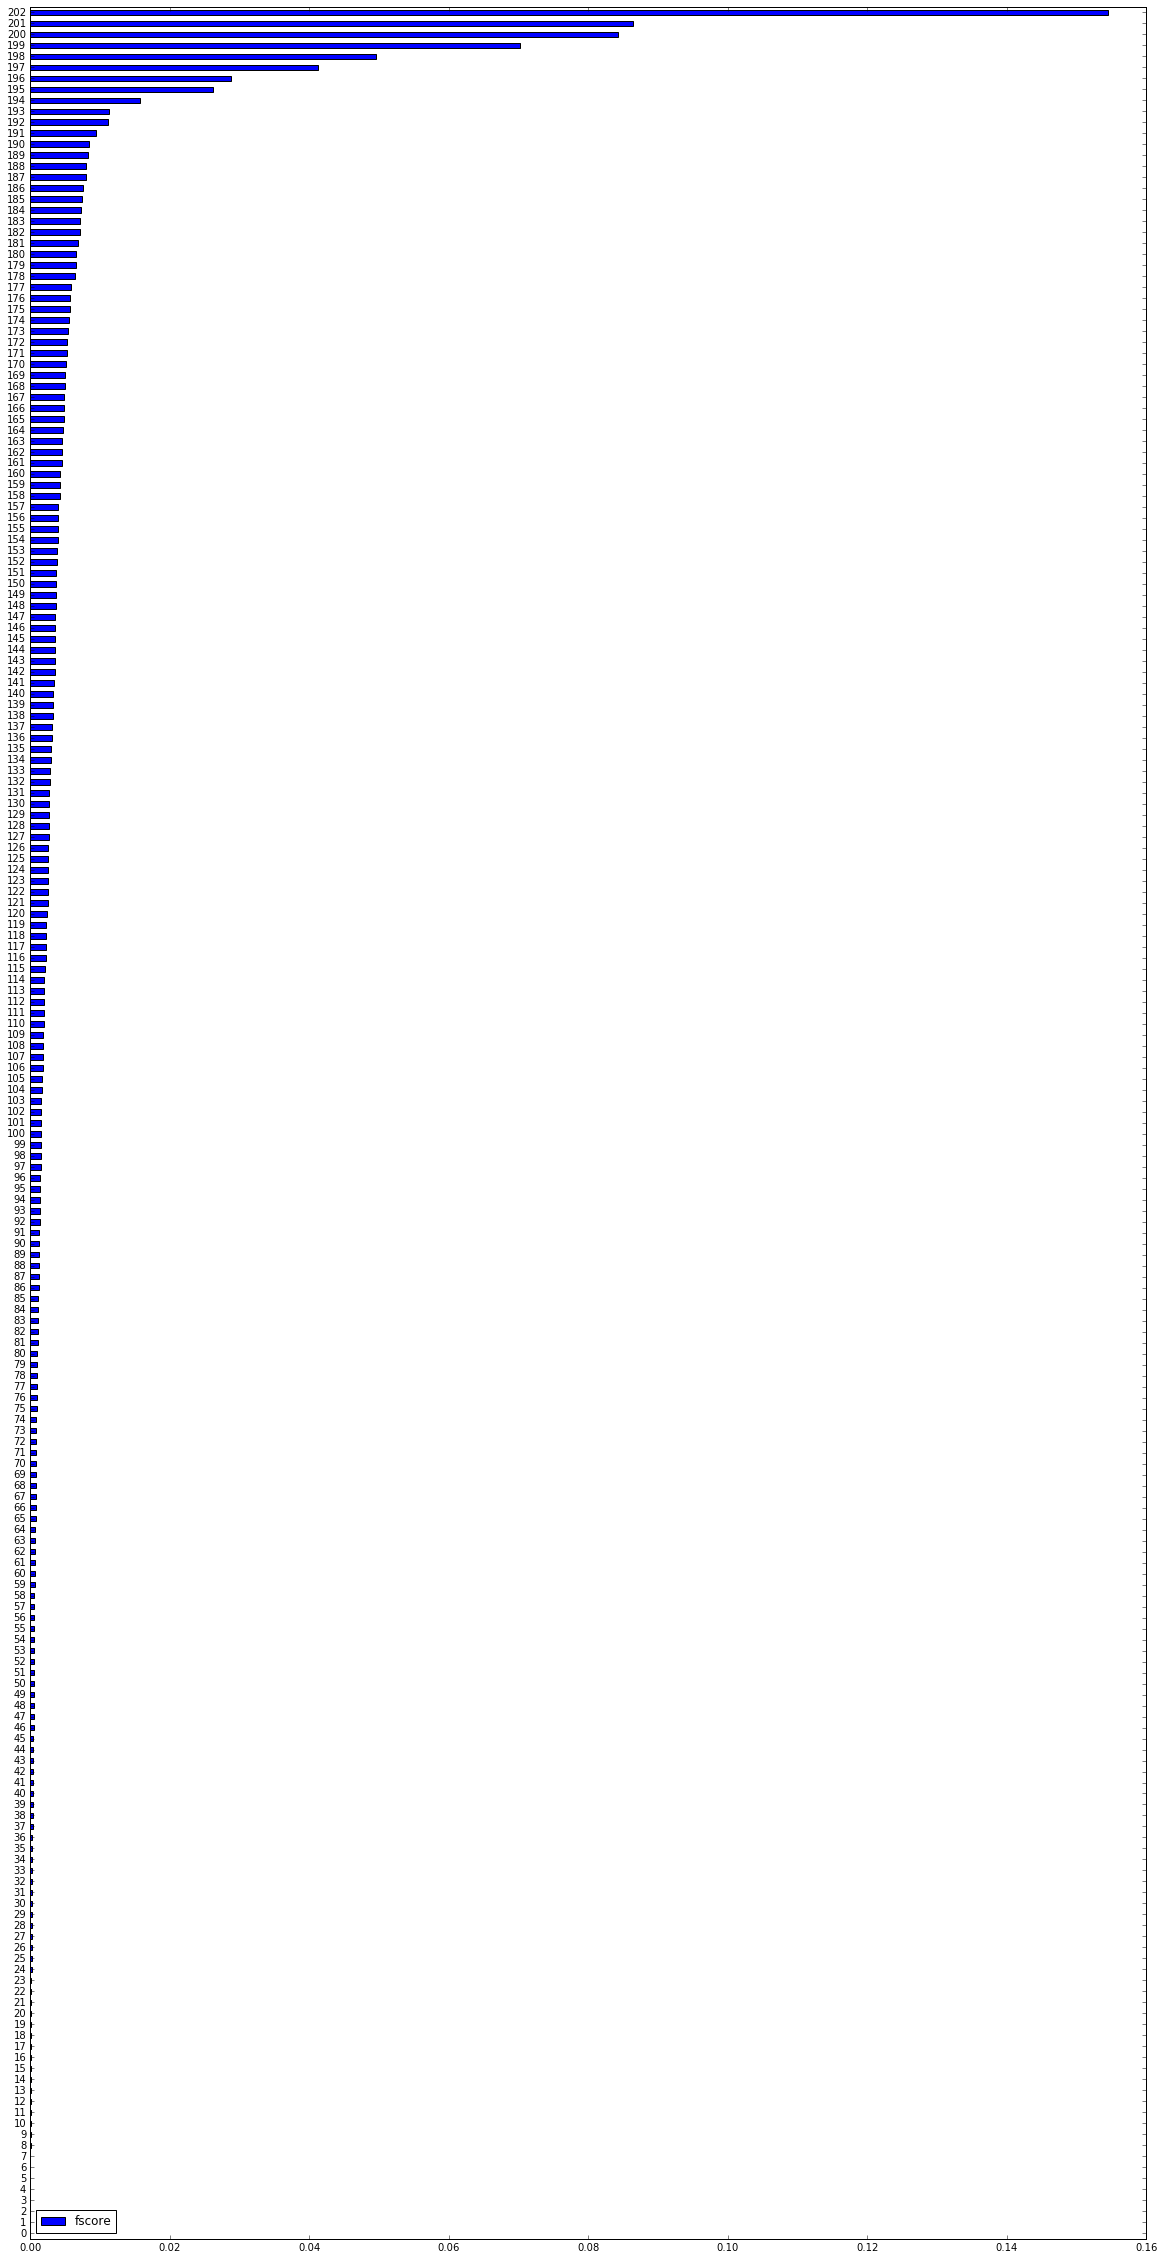

In [162]:
importance = gbdt.get_fscore()
importance = gbdt.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
d = df['fscore']/df['fscore'].sum()
print sum(d[-110:])
df['fscore'] = df['fscore'] / df['fscore'].sum()
df.plot(kind='barh', figsize=(20, 40))

In [139]:
 model = xgb.XGBRegressor(n_estimators=1).fit(np.array(dtrain[d[-110:].keys()]), np.array(ytrain))

Итак, мы получили три модели. Самая лучшая из них опказалась xgboost и по скорости сходимости и по качеству предсказаний. На втором месте оказалась градиентный список из sklearn и на третьем random forest. Правда стоит ометить, что не получилось зять именно лучшие параметры сетки. Так как, например,для RF лучшие параметры сетки max_features = 201, чего тут мы добиться не можем так как оганичили число признаков 95% процентами лучших. 

In [152]:
errors_all_features = get_sklearn_boosting_errors(dtrain, ytrain, 1, 30)
errors_choosen_features = get_sklearn_boosting_errors(dtrain[feature_importances.keys()], ytrain, 1, 30)
errors1 = {}
errors2 = {}
errors3 = {}
for i in xrange(1, 20):
    model = RandomForestRegressor(n_estimators=i, max_features=1, 
                                  min_samples_split=8).fit(dtrain[feature_importances1.keys()], ytrain)
    errors1[i] = mean_squared_error(ytest, model.predict(dtest[feature_importances1.keys()]))
    model = GradientBoostingRegressor(n_estimators=i, max_features=1, 
                                  min_samples_split=2).fit(dtrain[feature_importances2.keys()], ytrain)
    errors2[i] = mean_squared_error(ytest, model.predict(dtest[feature_importances2.keys()]))
    model = xgb.XGBRegressor(n_estimators=i).fit(np.array(dtrain[d[-110:].keys()]), np.array(ytrain))
    errors3[i] = mean_squared_error(np.array(ytest), model.predict(np.array(dtest[d[-110:].keys()])))

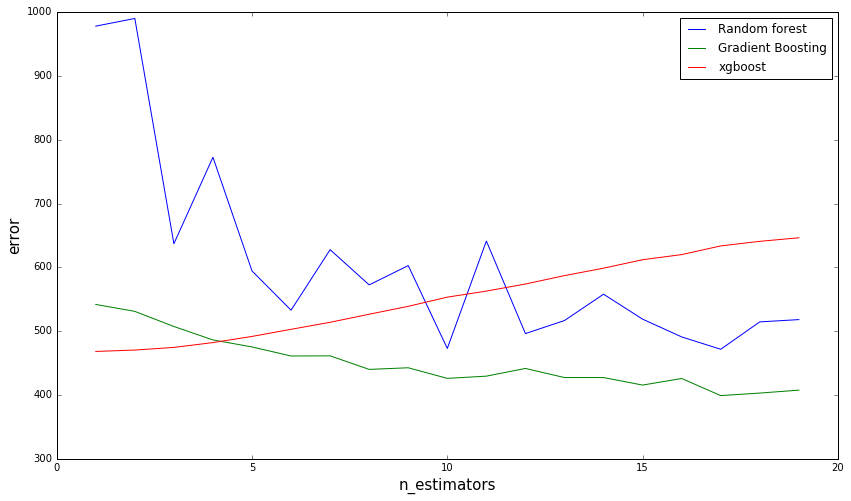

In [153]:
plt = plot_errors(errors1.keys(), errors1.values())
plt.plot(errors2.keys(), errors2.values())
plt.plot(errors3.keys(), errors3.values())
plt.legend(['Random forest', 'Gradient Boosting', 'xgboost'], loc='upper right')

In [165]:
errors_train1, error_test1 = {}, {}
errors_train2, error_test2 = {}, {}
errors_train3, error_test3 = {}, {}

for i in xrange(1, 1000, 50):
    model = RandomForestRegressor(n_estimators=i, max_features=1, min_samples_split=8).fit(dtrain, ytrain)
    errors_train1[i] = mean_squared_error(ytrain, model.predict(dtrain))
    error_test1[i] = mean_squared_error(ytest, model.predict(dtest))
    model = GradientBoostingRegressor(n_estimators=i, max_features=1, min_samples_split=2).fit(dtrain, ytrain)
    errors_train2[i] = mean_squared_error(ytrain, model.predict(dtrain))
    error_test2[i] = mean_squared_error(ytest, model.predict(dtest))
    model = xgb.XGBRegressor(n_estimators=1).fit(np.array(dtrain), np.array(ytrain))
    errors_train3[i] = mean_squared_error(np.array(ytrain), model.predict(np.array(dtrain)))
    error_test3[i] = mean_squared_error(ytest, model.predict(np.array(dtest)))

XGBoostError: std::bad_alloc

In [ ]:
plt = plot_errors(errors_train1.keys(), errors_train1.values())
plt.plot(errors_test1.keys(), errors_test1.values())
plt.legend(['train', 'test'], loc='upper right')

In [ ]:
plt = plot_errors(errors_train2.keys(), errors_train2.values())
plt.plot(error_test2.keys(), error_test2.values())
plt.legend(['train', 'test'], loc='upper right')

In [ ]:
plt = plot_errors(errors_train3.keys(), errors_train3.values())
plt.plot(error_test3.keys(), error_test3.values())
plt.legend(['train', 'test'], loc='upper right')

Тут у меня возникли проблемы с оперативкой. Но то что переобучние будет это я думаю точно.


В пункте 7, думаю прироста качества не будет.